# 3. Basic Statistics & Return Analysis

This notebook performs comprehensive statistical analysis of NVDA OHLC data, including:
- Summary statistics for all price and volume columns
- Return calculation and analysis
- Distribution analysis (skewness, kurtosis)
- Extreme return identification
- Statistical profiling of the dataset


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned data
all_data = pd.read_csv('combined_nvda_ohlc_clean.csv')
all_data['date'] = pd.to_datetime(all_data['date'])
all_data['datetime'] = pd.to_datetime(all_data['datetime'])

print(f"Loaded data shape: {all_data.shape}")
print(f"Date range: {all_data['date'].min()} to {all_data['date'].max()}")


Loaded data shape: (865782, 13)
Date range: 2021-01-04 00:00:00 to 2025-05-30 00:00:00


In [3]:
# Calculate minute-to-minute returns
all_data_sorted = all_data.sort_values('datetime').reset_index(drop=True)
all_data_sorted['returns'] = all_data_sorted['close'].pct_change()

# Remove infinite and NaN values for clean analysis
returns_clean = all_data_sorted['returns'].replace([np.inf, -np.inf], np.nan).dropna()

print("=== SUMMARY STATISTICS ===")
price_volume_cols = ['open', 'high', 'low', 'close', 'vwap', 'volume', 'transactions']
summary_stats = all_data[price_volume_cols].describe()
print(summary_stats)

print("\n=== ADDITIONAL PERCENTILES ===")
additional_percentiles = all_data[price_volume_cols].quantile([0.01, 0.05, 0.95, 0.99])
print(additional_percentiles)

print("\n=== POTENTIAL OUTLIERS (Beyond 99.9th percentile) ===")
for col in price_volume_cols:
    threshold = all_data[col].quantile(0.999)
    outliers = (all_data[col] > threshold).sum()
    print(f"{col}: {outliers} values above 99.9th percentile ({threshold:.2f})")


=== SUMMARY STATISTICS ===
                open           high            low          close  \
count  865782.000000  865782.000000  865782.000000  865782.000000   
mean       58.657110      58.692217      58.620466      58.657069   
std        45.787728      45.814661      45.759087      45.787682   
min        10.850100      10.882000      10.813000      10.854000   
25%        19.675000      19.688000      19.661050      19.676000   
50%        40.785000      40.800000      40.767000      40.786000   
75%       107.465000     107.560000     107.370000     107.467900   
max       153.680000     153.740000     153.590000     153.680000   

                vwap        volume   transactions  
count  865782.000000  8.657820e+05  865782.000000  
mean       58.651138  5.125698e+05    1133.565498  
std        45.781325  8.340971e+05    2229.541411  
min        10.851200  1.060000e+02       1.000000  
25%        19.676600  1.400000e+04      63.000000  
50%        40.782700  1.772155e+05     

## Return Analysis

Detailed analysis of minute-to-minute returns including distribution properties.


In [4]:
print("=== RETURN STATISTICS ===")
print(f"Total return observations: {len(returns_clean):,}")
print(f"Mean return per minute: {returns_clean.mean():.6f} ({returns_clean.mean()*100:.4f}%)")
print(f"Std deviation of returns: {returns_clean.std():.6f} ({returns_clean.std()*100:.4f}%)")
print(f"Skewness: {returns_clean.skew():.4f}")
print(f"Kurtosis: {returns_clean.kurtosis():.4f}")

print("\n=== RETURN PERCENTILES ===")
return_percentiles = returns_clean.quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])
for percentile, value in return_percentiles.items():
    print(f"{percentile*100:.1f}%: {value:.6f} ({value*100:.4f}%)")

print("\n=== EXTREME RETURNS ===")
print(f"Largest positive return: {returns_clean.max():.6f} ({returns_clean.max()*100:.4f}%)")
print(f"Largest negative return: {returns_clean.min():.6f} ({returns_clean.min()*100:.4f}%)")
print(f"Returns > 1%: {(returns_clean > 0.01).sum()} ({(returns_clean > 0.01).mean()*100:.3f}%)")
print(f"Returns < -1%: {(returns_clean < -0.01).sum()} ({(returns_clean < -0.01).mean()*100:.3f}%)")


=== RETURN STATISTICS ===
Total return observations: 865,781
Mean return per minute: 0.000003 (0.0003%)
Std deviation of returns: 0.001255 (0.1255%)
Skewness: -0.1693
Kurtosis: 181.5110

=== RETURN PERCENTILES ===
0.1%: -0.007470 (-0.7470%)
1.0%: -0.003376 (-0.3376%)
5.0%: -0.001653 (-0.1653%)
25.0%: -0.000429 (-0.0429%)
50.0%: 0.000000 (0.0000%)
75.0%: 0.000438 (0.0438%)
95.0%: 0.001642 (0.1642%)
99.0%: 0.003378 (0.3378%)
99.9%: 0.007933 (0.7933%)

=== EXTREME RETURNS ===
Largest positive return: 0.070180 (7.0180%)
Largest negative return: -0.081795 (-8.1795%)
Returns > 1%: 489 (0.056%)
Returns < -1%: 390 (0.045%)


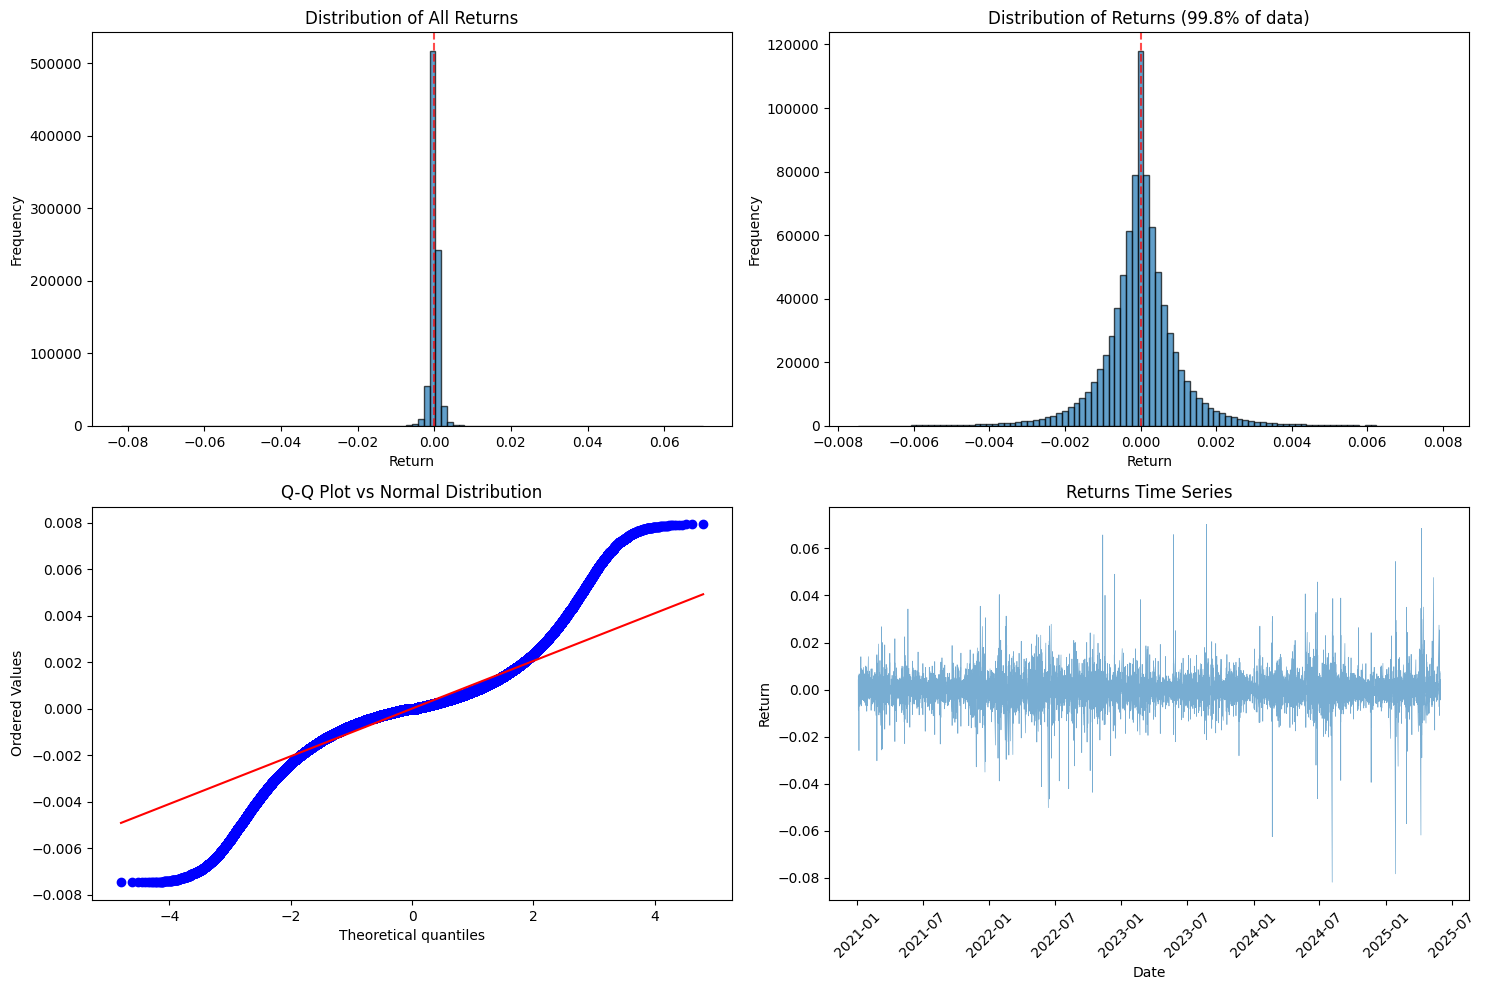

In [5]:
# Plot return distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of all returns
axes[0, 0].hist(returns_clean, bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of All Returns')
axes[0, 0].set_xlabel('Return')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# Histogram of returns (zoomed in, excluding extreme outliers)
returns_filtered = returns_clean[(returns_clean > returns_clean.quantile(0.001)) & 
                                (returns_clean < returns_clean.quantile(0.999))]
axes[0, 1].hist(returns_filtered, bins=100, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Returns (99.8% of data)')
axes[0, 1].set_xlabel('Return')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# Q-Q plot against normal distribution
from scipy import stats
stats.probplot(returns_filtered, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot vs Normal Distribution')

# Time series of returns
returns_with_time = all_data_sorted[['datetime', 'returns']].dropna()
axes[1, 1].plot(returns_with_time['datetime'], returns_with_time['returns'], alpha=0.6, linewidth=0.5)
axes[1, 1].set_title('Returns Time Series')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Return')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
